# Customer churn

The customer bank is losing clients.

To stop or at least slow down this process, we need to make a list of clients who can potentially terminate the contract with the bank.

We will solve this problem using machine learning methods based on data about customer behavior. We will try to train the models on different variants of the original dataset so as to take into account the imbalance of classes.

Since this is a classification task, the main metrics of model quality will be F1-score and AUC-ROC.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler 
from sklearn.utils import shuffle

from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.metrics import plot_roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

## Data preprocessing

In [2]:
try:
    data = pd.read_csv('Churn.csv')
except:
    data = pd.read_csv('/datasets/Churn.csv')

In [3]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Features
- RowNumber — row index in the data
- CustomerId — unique identifier of the customer
- Surname — last name
- CreditScore — credit rating
- Geography — country of residence
- Gender — gender
- Age — age
- Tenure — how many years a person has been a customer of the bank
- Balance — account balance
- NumOfProducts — number of bank products used by the client
- HasCrCard — credit card presence
- IsActiveMember — client's activity
- EstimatedSalary — estimated salary

Target feature
- Exited - the fact that the client has left

### Feature selection

1. We obviously do not need the RowNumber column, these numbers have nothing to do with the fact that the client left. Training the model with them will only deteriorate the quality.
2. CustomerID is probably not needed either. The only argument against it is that this number might reflect the order in which customers are registered (better to use date instead). I think it should be thrown out.
3. We probably don't need the surname either. Unless there is some sting involved, they should not be associated with the fact of the client's leaving. 
4. The data in the other columns may be related to the client churn.
5. There are missing values in the `Tenure` column, which should be investigated.
6. I wonder how it is determined that the client is active.

In [4]:
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           9091 non-null   float64
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


### Missing values

Let's have a look at the missing values in the `Tenure` column:

In [5]:
data.loc[data['Tenure'].isna()]

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
...,...,...,...,...,...,...,...,...,...,...,...
9944,744,Germany,Male,41,NaN,190409.34,2,1,1,138361.48,0
9956,520,France,Female,46,NaN,85216.61,1,1,0,117369.52,1
9964,479,France,Male,34,NaN,117593.48,2,0,0,113308.29,0
9985,659,France,Male,36,NaN,123841.49,2,1,0,96833.00,0


At first glance, there are no differences with the main dataset.

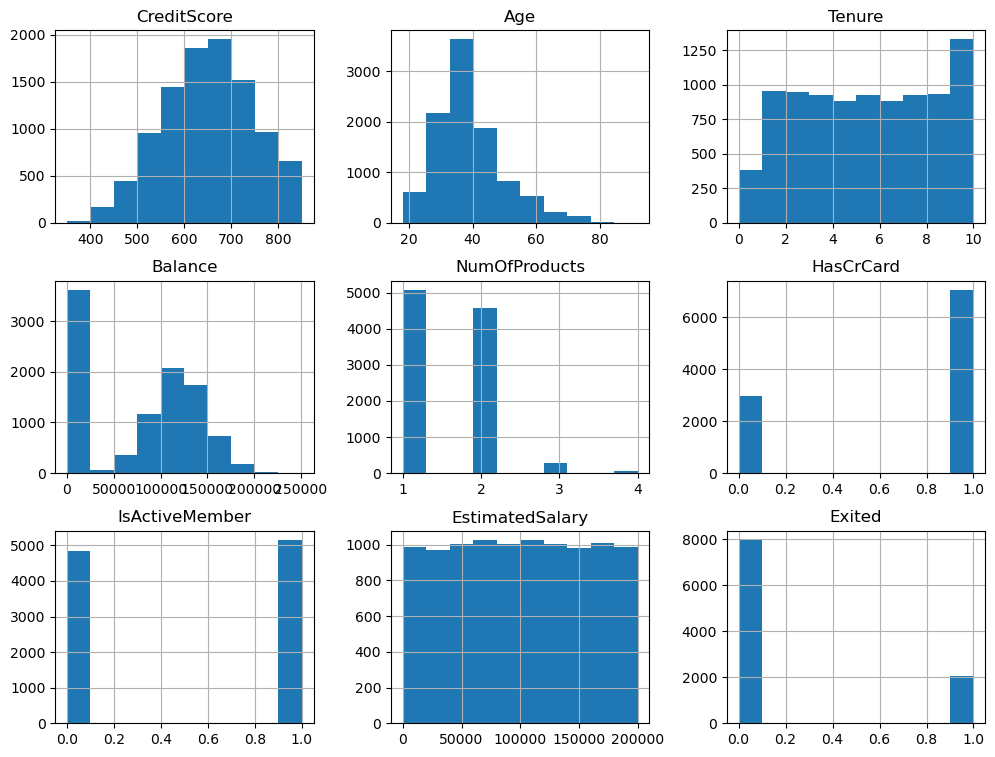

In [6]:
data.hist(figsize=(12, 9));

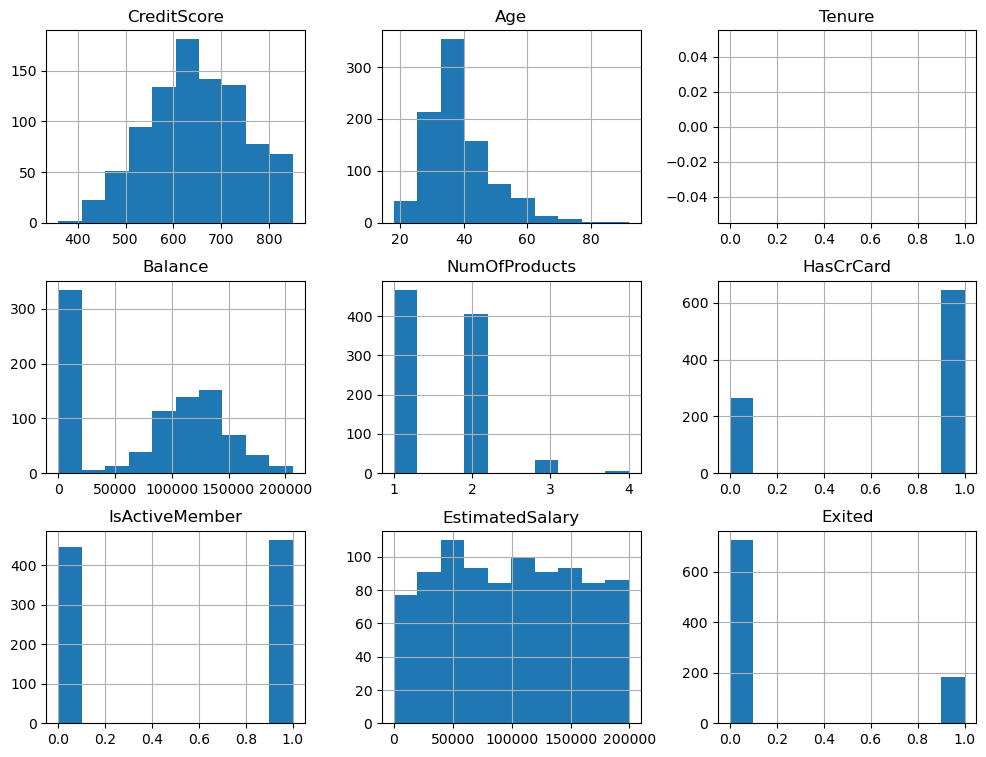

In [7]:
data.loc[data['Tenure'].isna()].hist(figsize=(12, 9));

I guess not.

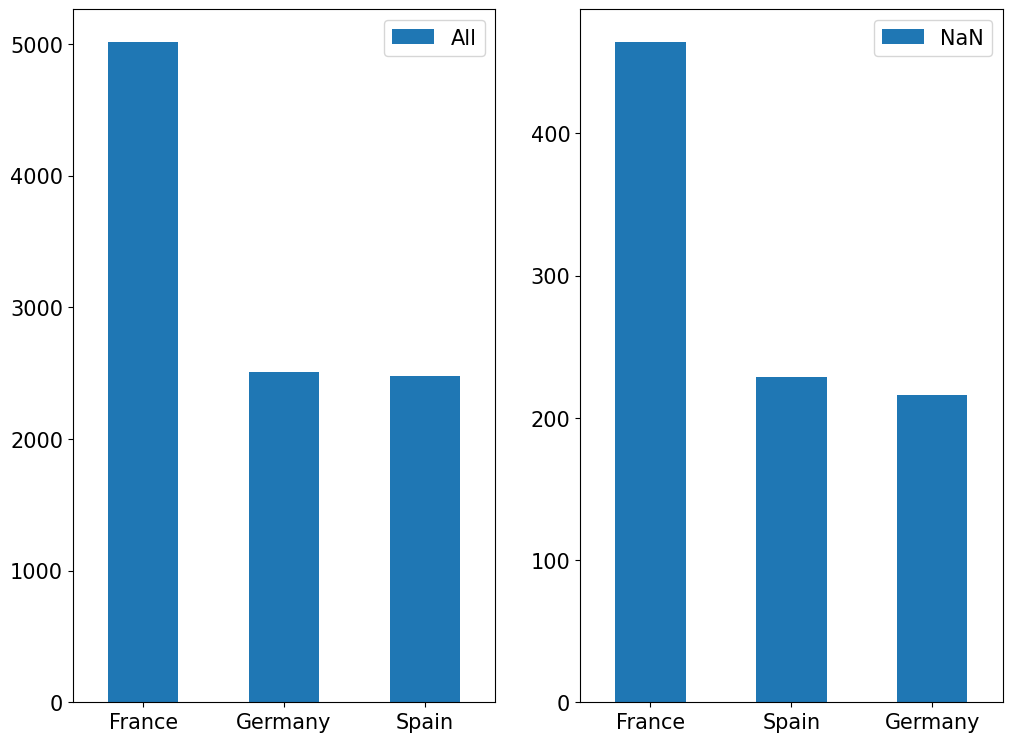

In [8]:
plt.subplot(1, 2, 1)
(data['Geography']
 .value_counts()
 .plot(kind='bar', label='All', rot=0, figsize=(12, 9)))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)

plt.subplot(1, 2, 2)
(data['Geography']
 .loc[data['Tenure'].isna()]
 .value_counts()
 .plot(kind='bar', label='NaN', rot=0, figsize=(12, 9)))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)

plt.show()

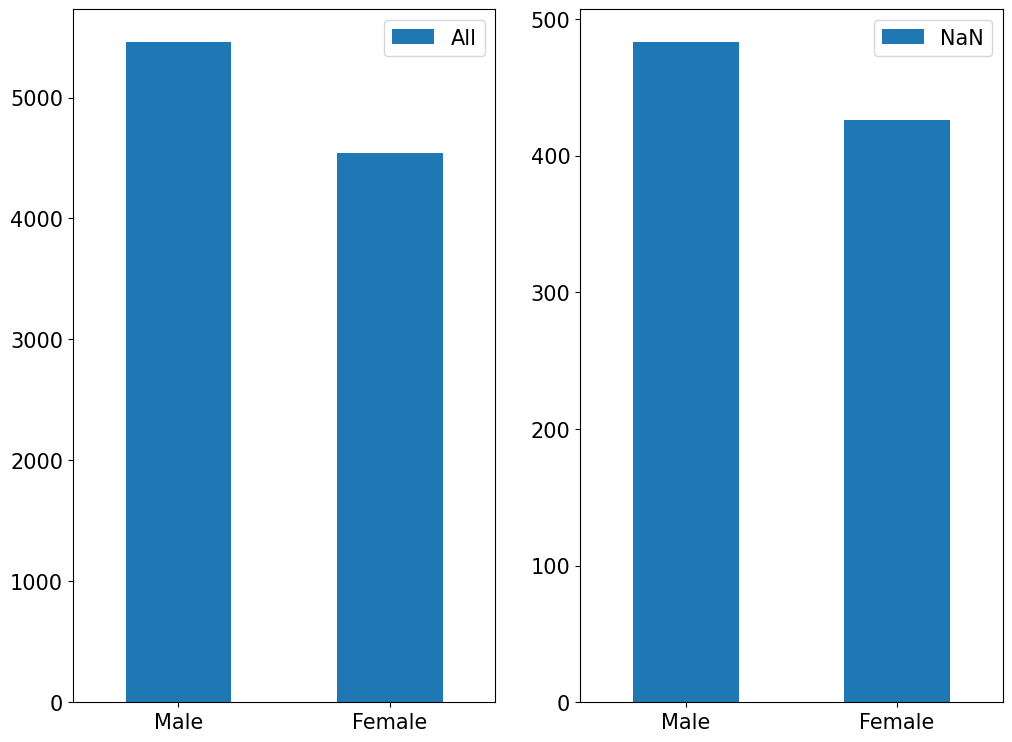

In [9]:
plt.subplot(1, 2, 1)
(data['Gender']
 .value_counts()
 .plot(kind='bar', label='All', rot=0, figsize=(12, 9)))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)

plt.subplot(1, 2, 2)
(data['Gender']
 .loc[data['Tenure'].isna()]
 .value_counts()
 .plot(kind='bar', label='NaN', rot=0, figsize=(12, 9)))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)

plt.show()

For categorical variables, too. It seems that the gaps have no logical explanation (i.e. random) and appeared as a result of a technical error.

The duration of the customer's agreement with the bank is an important parameter. Unfortunately, these 10% of the dataset will have to be discarded (if only because sklearn models do not work with missing values and will not be able to account for other data in these rows).

In [10]:
data = data.dropna(subset=['Tenure'])

### One-hot encoding

In [11]:
data.duplicated().sum()

0

There are no explicit duplicates.

In [12]:
data_ohe = pd.get_dummies(data, drop_first=True) # to avoid the dummy variable trap
data_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


There are no implicit duplicates either, otherwise there would be extra columns.  
The `drop_first=True` argument threw out two columns.

### Samples

In [13]:
features = data_ohe.drop('Exited', axis=1)
target = data_ohe['Exited']

(features_train, 
 features_valid, 
 features_test) = np.split(features.sample(frac=1, random_state=57), 
                           [int(0.6*len(features)), int(0.8*len(features))])
(target_train, 
 target_valid, 
 target_test) = np.split(target.sample(frac=1, random_state=57), 
                           [int(0.6*len(target)), int(0.8*len(target))])

In [14]:
features_train

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
2067,744,31,9.0,120718.28,1,1,1,58961.49,0,0,1
76,664,55,8.0,0.00,2,1,1,139161.64,0,0,1
2164,767,77,8.0,149083.70,1,1,1,190146.83,0,1,1
6892,649,56,8.0,156974.26,1,1,0,89405.26,0,0,0
7369,644,26,4.0,153455.72,2,1,1,82696.84,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
3113,620,32,7.0,0.00,2,1,1,34665.79,0,0,1
9475,616,46,2.0,0.00,2,1,0,137136.46,0,0,1
7003,646,44,2.0,113063.83,1,0,0,53072.49,1,0,0
4000,520,38,5.0,0.00,2,1,0,163185.76,0,0,1


In [15]:
target_valid

6380    1
4565    0
9322    0
604     0
5198    0
       ..
2830    0
7913    0
9126    1
3379    0
1757    1
Name: Exited, Length: 1818, dtype: int64

### Data scaling

We perform scaling based on the training sample data.

In [16]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
features_valid.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
6380,-0.500768,-0.372859,-1.369166,0.750231,-0.905589,1,0,0.894022,1,0,1
4565,-0.603863,0.663860,-1.025266,0.002282,-0.905589,1,1,-0.806120,0,1,0
9322,1.190006,-0.372859,1.382029,-1.221631,0.789943,1,0,-1.065109,0,0,0
604,0.519882,-0.184364,1.725928,1.183536,-0.905589,1,1,-0.108046,0,0,1
5198,-0.490458,0.098377,-1.369166,0.125591,-0.905589,0,0,-1.122351,0,0,1


To summarize:
1. The training was conducted without taking into account indexing, client identifiers and client surnames, as these data are unlikely to be related to the reason why the client left.
2. 9% missing at random data were found in the `Tenure` column. These rows were removed.
3. Two categorical variables, geographical location and client gender, were transformed using ohe-hot encoding, with data on one of countries and one of genders removed to avoid multicollinearity.
4. For numerical data, scaling was performed based on data from the training sample.

Let's train the model on data of this format.

## Selection functions

We will consider logistic regression, decision trees and random forest.

In [17]:
def plant_a_tree(def_features_train, 
                 def_target_train, 
                 def_features_valid, 
                 def_target_valid, 
                 balance=None):
    best_model = None
    best_depth = 0
    best_f1 = 0

    for depth in range(1, 20):
        def_model = DecisionTreeClassifier(max_depth=depth, 
                                           class_weight=balance, 
                                           random_state=57)
        def_model.fit(def_features_train, def_target_train)
        def_predicted_valid = def_model.predict(def_features_valid)
        current_f1 = f1_score(def_target_valid, def_predicted_valid)
        if current_f1 > best_f1:
            best_model = def_model
            best_depth = depth
            best_f1 = current_f1
            
    return best_model

Perhaps nested loops would give a more accurate result, but that's too long, so let's pick the depth first, then the number of trees.

In [18]:
def plant_a_forest(def_features_train, 
                   def_target_train, 
                   def_features_valid, 
                   def_target_valid, 
                   balance=None):
    # %%time
    best_depth = 0
    best_f1 = 0
    for depth in range(1, 30):
        def_model = RandomForestClassifier(n_estimators=30, 
                                           max_depth=depth, 
                                           class_weight=balance, 
                                           random_state=57)
        def_model.fit(def_features_train, def_target_train)
        def_predicted_valid = def_model.predict(def_features_valid)
        current_f1 = f1_score(def_target_valid, def_predicted_valid)
        if current_f1 > best_f1:
            best_depth = depth
            best_f1 = current_f1
    
    best_model = None
    best_est = 0
    best_f1 = 0
    for est in range(1, 100):
        def_model = RandomForestClassifier(n_estimators=est, 
                                           max_depth=best_depth, 
                                           class_weight=balance, 
                                           random_state=57)
        def_model.fit(def_features_train, def_target_train)
        def_predicted_valid = def_model.predict(def_features_valid)
        current_f1 = f1_score(def_target_valid, def_predicted_valid)
        if current_f1 > best_f1:
            best_model = def_model
            best_est = est
            best_f1 = current_f1
            
    return best_model

In [19]:
def plot_confusion_matrix(def_model, def_features_valid, def_target_valid):
    def_predicted_valid = def_model.predict(def_features_valid)

    print('Confusion matrix:')
    print(confusion_matrix(def_target_valid, def_predicted_valid))
    
    fig, ax = plt.subplots()
    fig = sb.heatmap(confusion_matrix(def_target_valid, def_predicted_valid, normalize='true'), 
                     annot=True)
    plt.yticks(rotation=0)
    ax.set_ylabel('Answers', rotation=0);
    ax.set_xlabel('Predictions');
    ax.yaxis.labelpad = 20
    plt.show()

In [20]:
def roc_graph(def_model, def_features_valid, def_target_valid):
    def_predicted_valid = def_model.predict(def_features_valid)
    
    print('Recall:', recall_score(def_target_valid, def_predicted_valid))
    print('Precision:', precision_score(def_target_valid, def_predicted_valid))
    print('F1-score:', f1_score(def_target_valid, def_predicted_valid))
    
    plot_roc_curve(def_model, def_features_valid, def_target_valid);
    plt.show()

## Training without balancing

### Logistic regression

LogisticRegression:
Accuracy: 0.8201320132013201 

Confusion matrix:
[[1417   60]
 [ 267   74]]


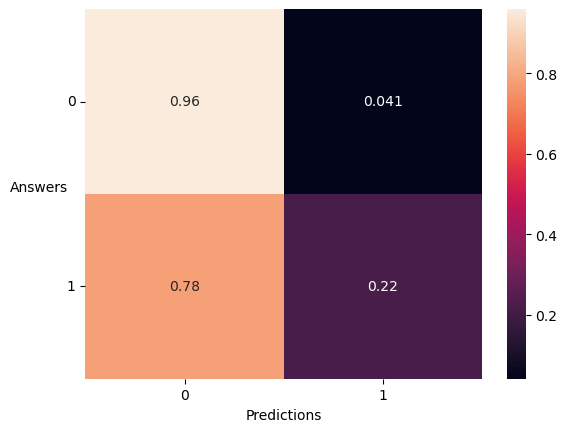

Recall: 0.21700879765395895
Precision: 0.5522388059701493
F1-score: 0.311578947368421


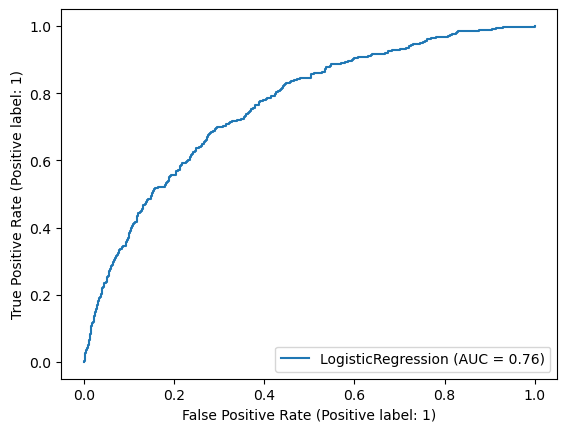

In [21]:
model = LogisticRegression(solver='liblinear', random_state=57)
model.fit(features_train, target_train)

print('LogisticRegression:')
print('Accuracy:', model.score(features_valid, target_valid), '\n')
plot_confusion_matrix(model, features_valid, target_valid)
roc_graph(model, features_valid, target_valid)

So many type II errors.

### Decision Tree

DecisionTreeClassifier:
Accuracy: 0.8641364136413642
Depth: 7 

Confusion matrix:
[[1405   72]
 [ 175  166]]


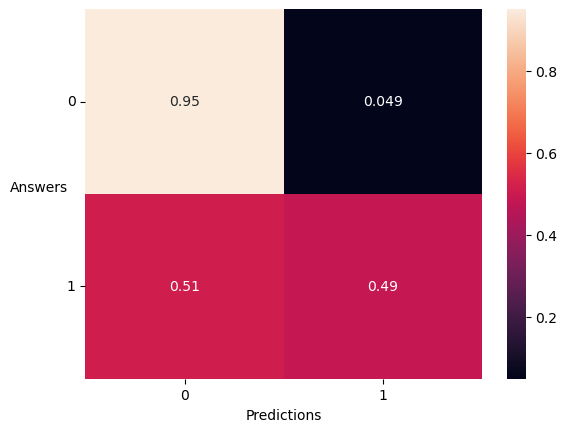

Recall: 0.4868035190615836
Precision: 0.6974789915966386
F1-score: 0.5734024179620034


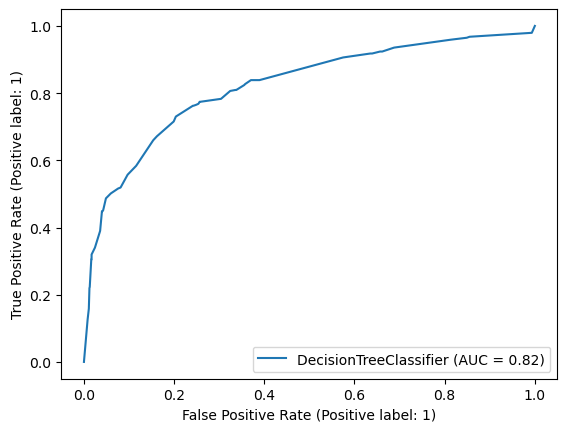

In [22]:
best_tree = plant_a_tree(features_train, target_train, features_valid, target_valid)

print('DecisionTreeClassifier:')
print('Accuracy:', best_tree.score(features_valid, target_valid))
print('Depth:', best_tree.max_depth, '\n')

plot_confusion_matrix(best_tree, features_valid, target_valid)
roc_graph(best_tree, features_valid, target_valid)

Noticeable progress compared to regression. There are almost as many errors as correct answers (regarding the positive class).

### Random Forest

RandomForestClassifier:
Accuracy: 0.8745874587458746
Depth: 18
Estimators: 22 

Confusion matrix:
[[1424   53]
 [ 175  166]]


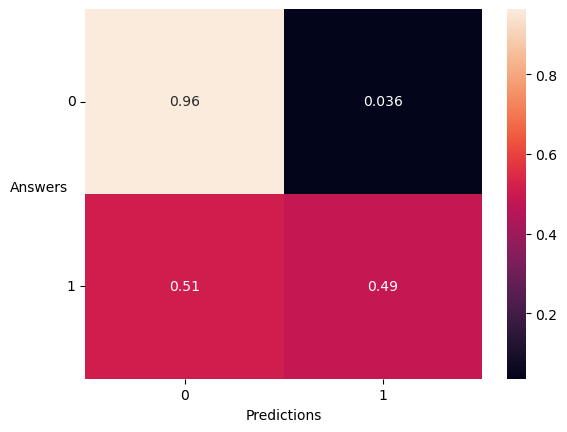

Recall: 0.4868035190615836
Precision: 0.7579908675799086
F1-score: 0.5928571428571429


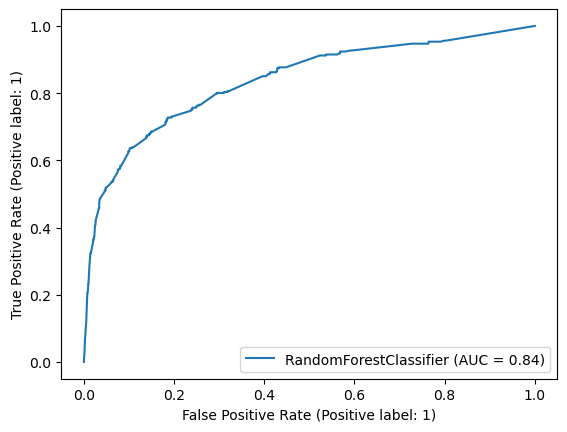

CPU times: user 49 s, sys: 298 ms, total: 49.3 s
Wall time: 49.3 s


In [23]:
%%time
best_forest = plant_a_forest(features_train, target_train, features_valid, target_valid)

print('RandomForestClassifier:')
print('Accuracy:', best_forest.score(features_valid, target_valid))
print('Depth:', best_forest.max_depth)
print('Estimators:', best_forest.n_estimators, '\n')

plot_confusion_matrix(best_forest, features_valid, target_valid)
roc_graph(best_forest, features_valid, target_valid)

AUC-ROC slightly increased, although one is predicted less frequently than in the decision tree. Apparently, it is connected with better prediction of zeros.

The metrics themselves are almost acceptable for models without class balancing, but the number of correctly found positive class objects has to be increased.

## Training with balancing

Now let's look at the balance of the classes.

In [24]:
data_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


In [25]:
data_ohe['Exited'].value_counts()

0    7237
1    1854
Name: Exited, dtype: int64

Let's try to train with balance only.

### Logistic regression

LogisticRegression:
Accuracy: 0.7062706270627063 

Confusion matrix:
[[1056  421]
 [ 113  228]]


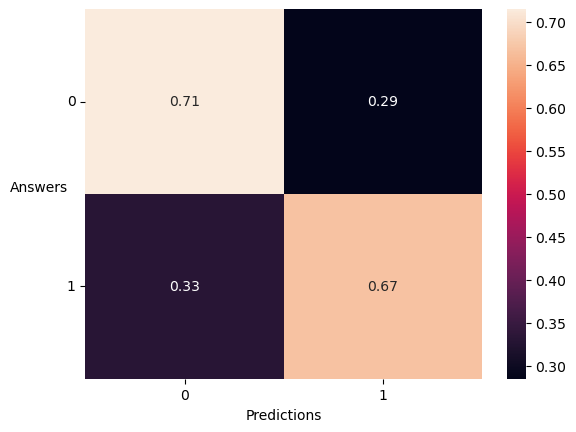

Recall: 0.6686217008797654
Precision: 0.35130970724191063
F1-score: 0.46060606060606063


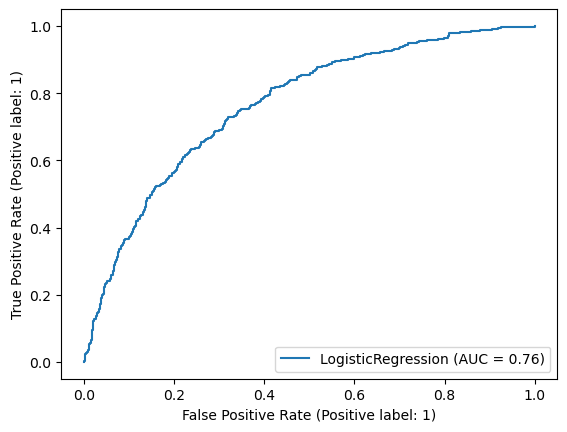

In [26]:
model = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=57)
model.fit(features_train, target_train)

print('LogisticRegression:')
print('Accuracy:', model.score(features_valid, target_valid), '\n')
plot_confusion_matrix(model, features_valid, target_valid)
roc_graph(model, features_valid, target_valid)

This matrix is already more like what we would like to see. Too bad the ROC-AUC is low.

### Decision Tree

DecisionTreeClassifier:
Accuracy: 0.7876787678767877
Depth: 8 

Confusion matrix:
[[1179  298]
 [  88  253]]


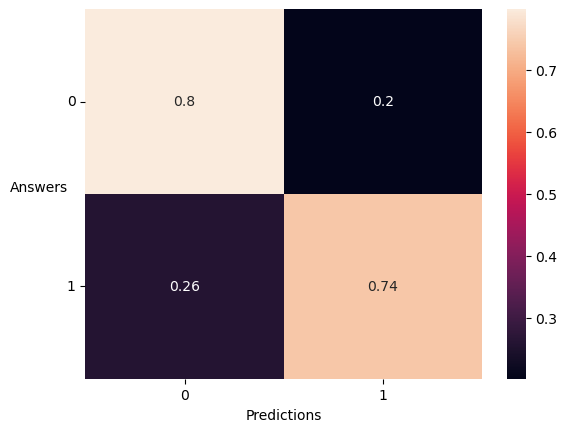

Recall: 0.7419354838709677
Precision: 0.4591651542649728
F1-score: 0.5672645739910314


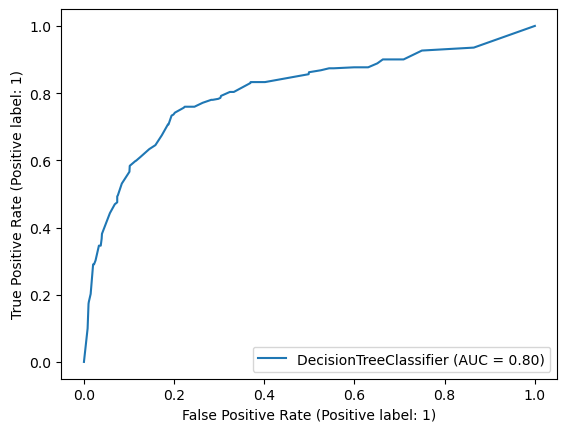

In [27]:
best_tree = plant_a_tree(features_train, target_train, features_valid, target_valid, 'balanced')

print('DecisionTreeClassifier:')
print('Accuracy:', best_tree.score(features_valid, target_valid))
print('Depth:', best_tree.max_depth, '\n')

plot_confusion_matrix(best_tree, features_valid, target_valid)
roc_graph(best_tree, features_valid, target_valid)

The tree is an even better predictor. Let's see what happens with a random forest.

### Random Forest

RandomForestClassifier:
Accuracy: 0.858085808580858
Depth: 10
Estimators: 26 

Confusion matrix:
[[1344  133]
 [ 125  216]]


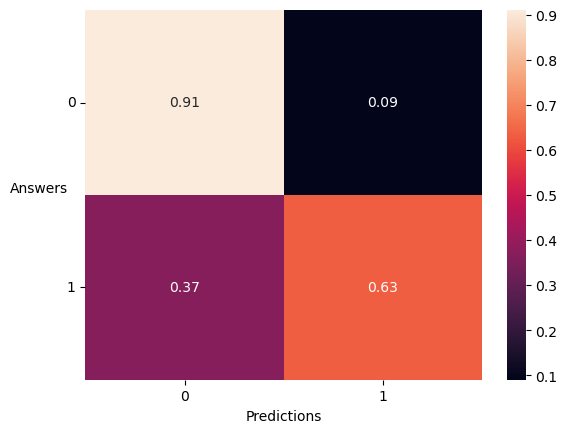

Recall: 0.6334310850439883
Precision: 0.6189111747851003
F1-score: 0.6260869565217392


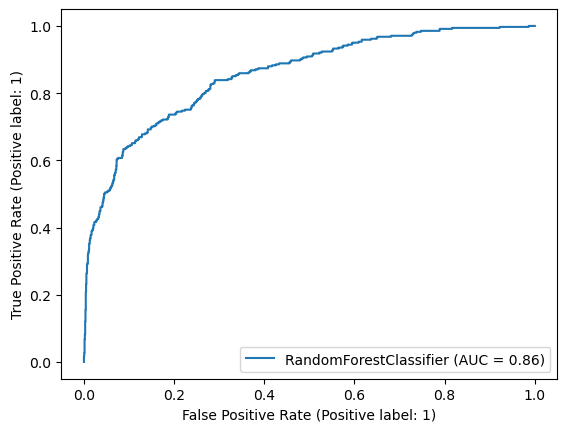

CPU times: user 42.8 s, sys: 244 ms, total: 43.1 s
Wall time: 43 s


In [28]:
%%time
best_forest = plant_a_forest(features_train, target_train, features_valid, target_valid, 
                             'balanced')

print('RandomForestClassifier:')
print('Accuracy:', best_forest.score(features_valid, target_valid))
print('Depth:', best_forest.max_depth)
print('Estimators:', best_forest.n_estimators, '\n')

plot_confusion_matrix(best_forest, features_valid, target_valid)
roc_graph(best_forest, features_valid, target_valid)

Here we observe a skewness.

The F1-score of the random forest is 0.626, which is higher than all previous models.

However, the error matrix shows that this was achieved due to the better prediction of zeros, while ones are predicted even worse than by the decision tree. This does not quite meet our goals. More than a third of our target customers stay unrecognized.

Let's try to equalize the sample.

## Training on balanced sample

In [29]:
ratio = data_ohe['Exited'].sum() / len(data_ohe['Exited'])
ratio

0.2039379606203938

Leaving customers in the dataset are 4 times less frequent than remaining customers. So the imbalance is 1:4.

The balance of classes is not so badly shifted. Let's increase **four times** the number of positive lines and leave the number of negative lines unchanged.

In [30]:
def upsample_downsample(def_features, def_target, up, down):
    features_zeros = def_features[def_target == 0]
    features_ones = def_features[def_target == 1]
    target_zeros = def_target[def_target == 0]
    target_ones = def_target[def_target == 1]
    
    features_sampled = pd.concat([features_zeros.sample(frac=1/down, random_state=57)] + 
                                 [features_ones] * up)
    target_sampled = pd.concat([target_zeros.sample(frac=1/down, random_state=57)] + 
                                 [target_ones] * up)
    
    features_sampled, target_sampled = shuffle(features_sampled, 
                                               target_sampled, 
                                               random_state=57)
    
    return features_sampled, target_sampled

In [31]:
print(features_train.shape)
print(target_train.shape)

(5454, 11)
(5454,)


In [32]:
features_sampled, target_sampled = upsample_downsample(features_train, target_train, 4, 1)

In [33]:
target_sampled.value_counts()

1    4476
0    4335
Name: Exited, dtype: int64

### Logistic regression

LogisticRegression:
Accuracy: 0.7062706270627063 

Confusion matrix:
[[1056  421]
 [ 113  228]]


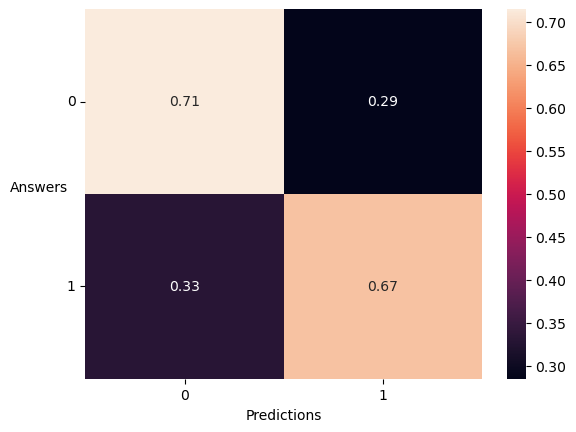

Recall: 0.6686217008797654
Precision: 0.35130970724191063
F1-score: 0.46060606060606063


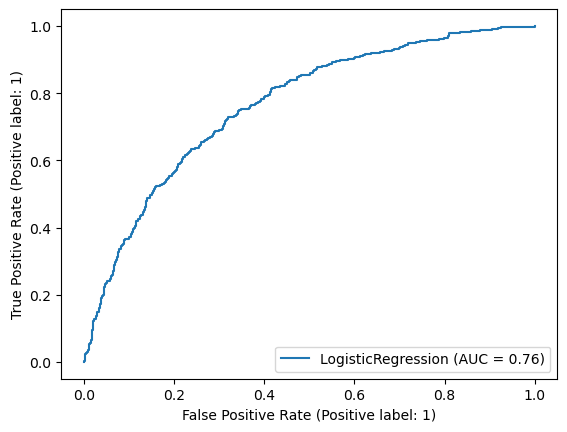

In [34]:
model = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=57)
model.fit(features_sampled, target_sampled)

print('LogisticRegression:')
print('Accuracy:', model.score(features_valid, target_valid), '\n')
plot_confusion_matrix(model, features_valid, target_valid)
roc_graph(model, features_valid, target_valid)

Logistic regression returns the same result regardless of algorithm, number of iterations and multiplication of strings with positive objects. Only class weights can affect it.

### Decision Tree

DecisionTreeClassifier:
Accuracy: 0.7871287128712872
Depth: 8 

Confusion matrix:
[[1177  300]
 [  87  254]]


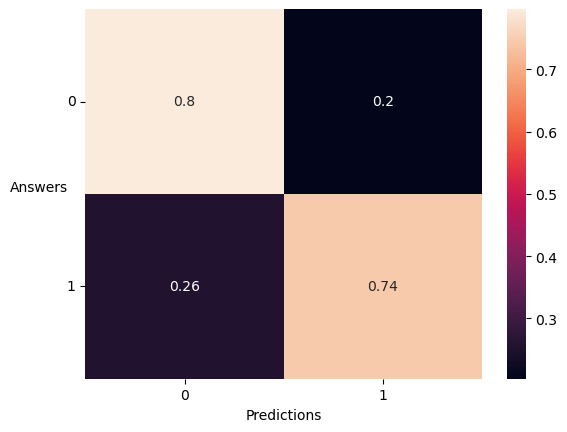

Recall: 0.7448680351906158
Precision: 0.4584837545126354
F1-score: 0.5675977653631284


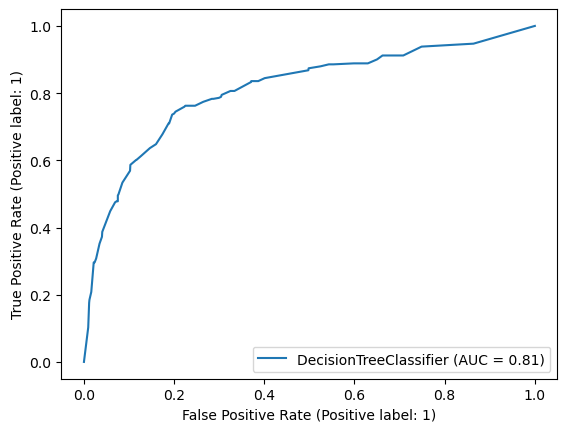

In [35]:
best_tree = plant_a_tree(features_sampled, target_sampled, features_valid, target_valid, 
                         'balanced')

print('DecisionTreeClassifier:')
print('Accuracy:', best_tree.score(features_valid, target_valid))
print('Depth:', best_tree.max_depth, '\n')

plot_confusion_matrix(best_tree, features_valid, target_valid)
roc_graph(best_tree, features_valid, target_valid)

### Random Forest

RandomForestClassifier:
Accuracy: 0.8591859185918592
Depth: 13
Estimators: 68 

Confusion matrix:
[[1344  133]
 [ 123  218]]


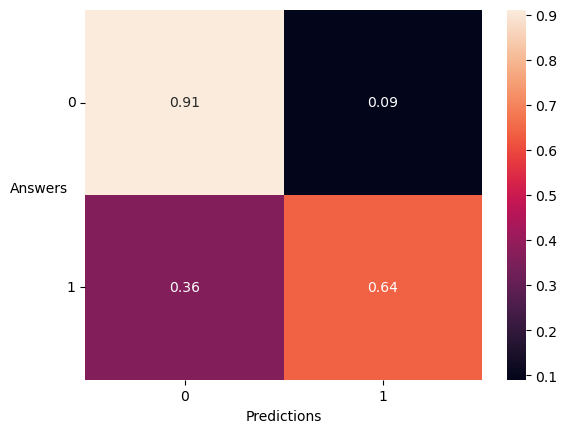

Recall: 0.6392961876832844
Precision: 0.6210826210826211
F1-score: 0.630057803468208


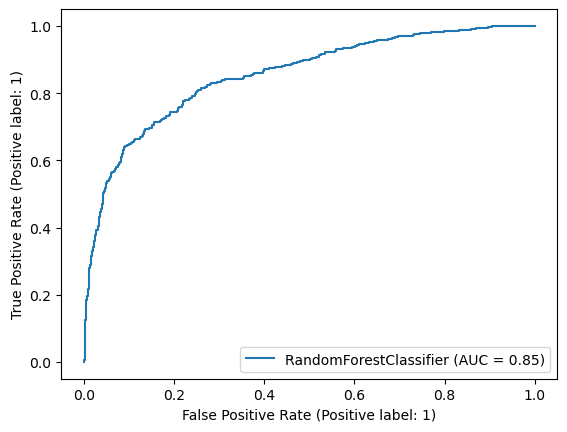

CPU times: user 1min 7s, sys: 229 ms, total: 1min 7s
Wall time: 1min 7s


In [36]:
%%time
best_forest = plant_a_forest(features_sampled, target_sampled, features_valid, target_valid, 
                             'balanced')

print('RandomForestClassifier:')
print('Accuracy:', best_forest.score(features_valid, target_valid))
print('Depth:', best_forest.max_depth)
print('Estimators:', best_forest.n_estimators, '\n')

plot_confusion_matrix(best_forest, features_valid, target_valid)
roc_graph(best_forest, features_valid, target_valid)

It's a little better compared to the original splitting.

## Model selection

The highest metric comes from models that give weights to classes and are built on samples where the ratio of zeros to ones is about 1:1 (that is, rows with positive objects are 4 times more common than originally).

Here are the statistics for the models:

|Model|Recall|Precision|F1-score|AUC-ROC|
|---|---|---|---|---|
|Logistic regression|0.669|0.351|0.461|0.76|
|Decision tree|**0.745**|0.458|0.568|0.81|
|Random forest|0.639|**0.621**|**0.630**|**0.85**|

Here, the logistic regression is constructed using the liblinear algorithm, the decision tree has a depth of 8, and the random forest consists of 68 trees with a depth of 13.

Random forest has the highest F1-score, but it is achieved by recognizing zeros rather than ones.

This is where the question of business goals raises. If we need to retain as many customers as possible, recall is more important than accuracy, and I would take the decision tree even if it didn't pass the F1 > 0.59 threshold. However, since we have this requirement, let's keep the random forest.

## Sanity check

To test the model for sanity, let's compare it to a model that predicts classes based on their frequency.

DummyClassifier:
Accuracy: 0.6842684268426843 

Confusion matrix:
[[1172  305]
 [ 269   72]]


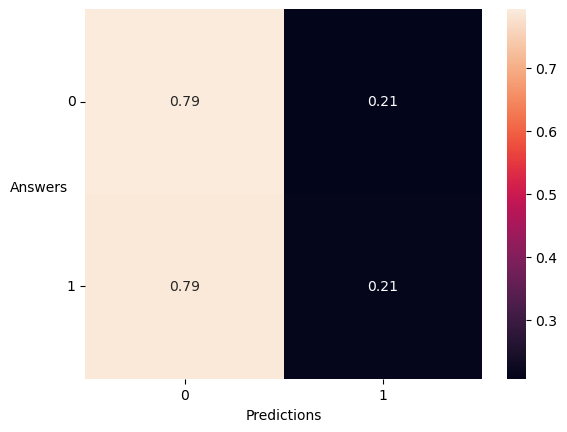

Recall: 0.21114369501466276
Precision: 0.1909814323607427
F1-score: 0.20055710306406685


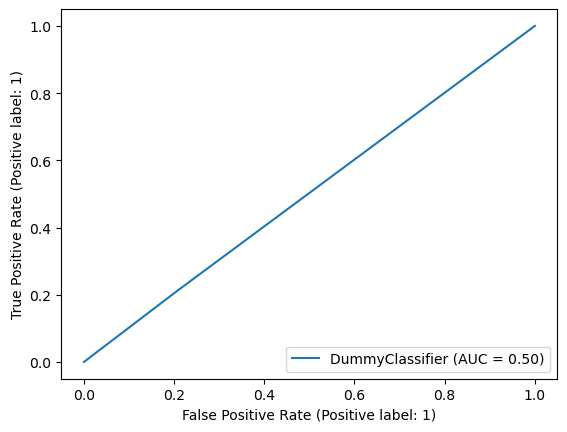

In [37]:
dummy_clf = DummyClassifier(strategy='stratified', random_state=57)
dummy_clf.fit(features_train, target_train)
dummy_clf.score(features_valid, target_valid)

print('DummyClassifier:')
print('Accuracy:', dummy_clf.score(features_valid, target_valid), '\n')

plot_confusion_matrix(dummy_clf, features_valid, target_valid)
roc_graph(dummy_clf, features_valid, target_valid)

Or a model that predicts only positive class.

DummyClassifier:
Accuracy: 0.18756875687568758 

Recall: 1.0
Precision: 0.18756875687568758
F1-score: 0.3158869847151459


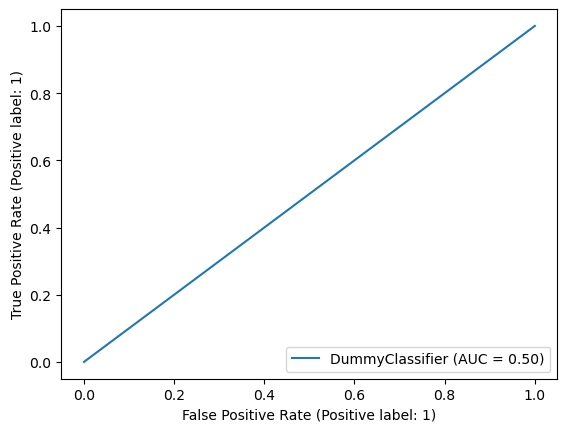

In [38]:
dummy_clf = DummyClassifier(strategy='constant', constant=1)
dummy_clf.fit(features_train, target_train)
dummy_clf.score(features_valid, target_valid)

print('DummyClassifier:')
print('Accuracy:', dummy_clf.score(features_valid, target_valid), '\n')

# plot_confusion_matrix(dummy_clf, features_valid, target_valid)
roc_graph(dummy_clf, features_valid, target_valid)

The selected random forest has a slightly higher acuracy and a noticeably higher F1-score.

## Testing

RandomForestClassifier:
Accuracy: 0.8328752061572292
Depth: 13
Estimators: 68 

Confusion matrix:
[[1283  142]
 [ 162  232]]


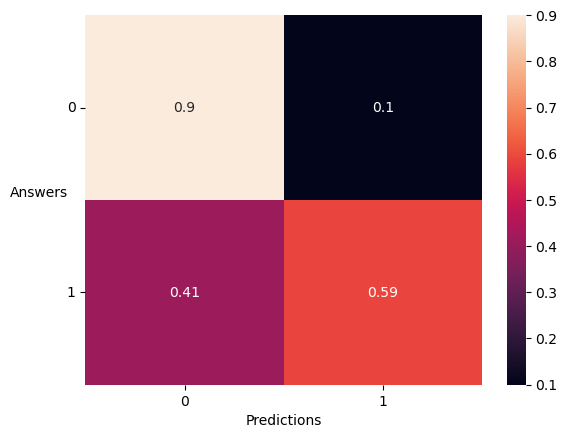

Recall: 0.5888324873096447
Precision: 0.6203208556149733
F1-score: 0.6041666666666666


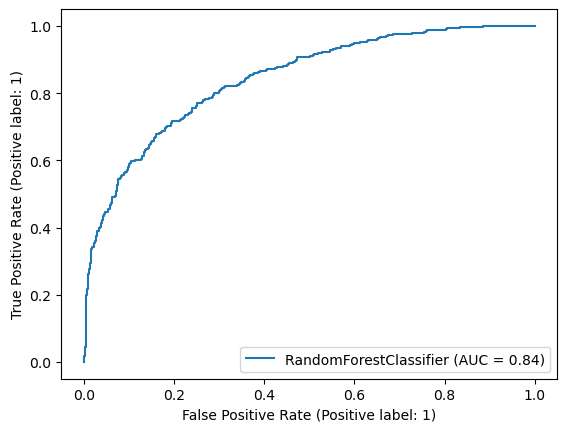

In [39]:
model = RandomForestClassifier(n_estimators=68, max_depth=13, 
                               class_weight='balanced', random_state=57)

model.fit(features_sampled, target_sampled)
predicted_test = model.predict(features_test)

print('RandomForestClassifier:')
print('Accuracy:', model.score(features_test, target_test))
print('Depth:', model.max_depth)
print('Estimators:', model.n_estimators, '\n')

print('Confusion matrix:')
print(confusion_matrix(target_test, predicted_test))
fig, ax = plt.subplots()
fig = sb.heatmap(confusion_matrix(target_test, predicted_test, normalize='true'), annot=True)
plt.yticks(rotation=0)
ax.set_ylabel('Answers', rotation=0);
ax.set_xlabel('Predictions');
ax.yaxis.labelpad = 20
plt.show()

print('Recall:', recall_score(target_test, predicted_test))
print('Precision:', precision_score(target_test, predicted_test))
print('F1-score:', f1_score(target_test, predicted_test))
plot_roc_curve(model, features_test, target_test);
plt.show()

Recall has dropped significantly (0.639 => 0.589). F1-score also decreased (0.630 => 0.604), but still above the threshold.

Out of interest, let's try to select a random forest with training on both test and validation samples.

The imbalance in the samples is preserved here and is taken into account only by the model.

RandomForestClassifier:
Accuracy: 0.8152831225948324
Depth: 8
Estimators: 22 

Confusion matrix:
[[1214  211]
 [ 125  269]]


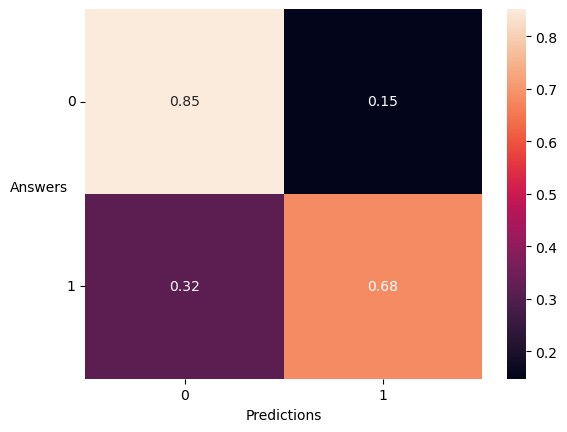

Recall: 0.682741116751269
Precision: 0.5604166666666667
F1-score: 0.6155606407322655


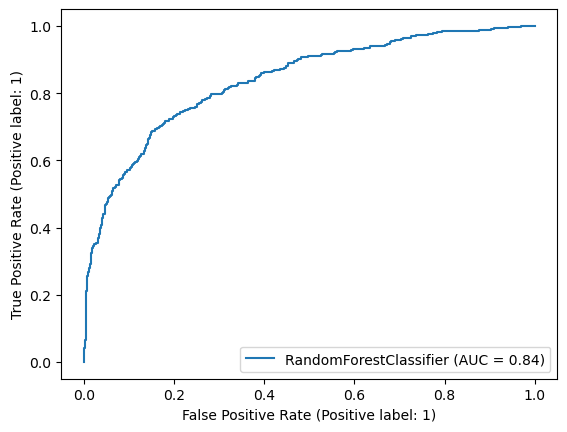

In [40]:
perfect_forest = plant_a_forest(pd.concat([features_train, features_valid]), 
                                pd.concat([target_train, target_valid]), 
                                features_test, 
                                target_test, 
                                'balanced')
print('RandomForestClassifier:')
print('Accuracy:', perfect_forest.score(features_test, target_test))
print('Depth:', perfect_forest.max_depth)
print('Estimators:', perfect_forest.n_estimators, '\n')

plot_confusion_matrix(perfect_forest, features_test, target_test)
roc_graph(perfect_forest, features_test, target_test)

Both metrics have grown, but this is more of an overfitting effect, because the loop adjusts the hyperparameters to the metrics. Let's leave it as it was.

## Conclusions

|Model|Recall|Precision|F1-score|AUC-ROC|
|---|---|---|---|---|
|Logistic regression|0.669|0.351|0.461|0.76|
|Decision tree|**0.745**|0.458|0.568|0.81|
|Random forest|0.639|**0.621**|**0.630**|**0.85**|

1. There are 9% missing (most likely, accidentally) values among the data on the duration of customer agreement with the bank. These people were not taken into account in this work.
2. Class balancing noticeably improves the quality of the model. Both assigning weights to classes (according to imbalance) and increasing the frequency of occurrence of positive class objects (by a factor of 4) help significantly. Models using both are discussed below.
3. Logistic regression showed lower metric compared to the trees. Although it predicts leaving clients no worse than a random forest, it does much more type I errors.
4. Decision trees show good recall (at a depth of 8), but due to low precision it did not pass the threshold of 0.59. Depending on the objectives, this model can be taken into account.
5. Random forest has the highest score (with 68 trees of depth 13). Nevertheless, these numbers are achieved due to the good predictions for negative class objects, while the recall according to the test results leaves much to be desired.
6. According to the test results, F1-score was 0.604, recall - 0.589, i.e. the model tend to do type II errors.